# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub> (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'O3'

# Define sensor
sensor = 'iasi'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 90

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2020-01-01'
end_date = '2020-01-02'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: ('2020-01-01', '2020-01-02')


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [7]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 4, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-05T20:28 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [8]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Download and read data as xarray

In [9]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, dates)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.3M  100 11.3M    0     0  36.0M      0 --:--:-- --:--:-- --:--:-- 36.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  43.8M      0 --:--:-- --:--:-- --:--:-- 43.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.2M  100 11.2M    0     0  46.0M      0 --:--:-- --:--:-- --:--:-- 46.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.2M  100 11.2M    0     0  48.6M      0 --:--:-- --:--:-- --:--:-- 48.6M
  % Total    % Received % Xferd  Average Speed   Tim

In [10]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, sensor_product_names)
sensor_ds

/tmp/ipykernel_2222106/1762921100.py:58: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_2222106/1762921100.py:58: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.DataArray 'O3_total_column' (time: 2, latitude: 180, longitude: 360)>
array([[[0.19255446, 0.15953487,        nan, ..., 0.16442926,
         0.17539772,        nan],
        [0.15635489, 0.15712069,        nan, ...,        nan,
         0.14956175,        nan],
        [       nan, 0.15362976, 0.15085714, ..., 0.15756053,
         0.17537636,        nan],
        ...,
        [0.1352897 ,        nan,        nan, ...,        nan,
         0.13260613,        nan],
        [       nan, 0.14007668,        nan, ...,        nan,
         0.13800772,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan, 0.1577743 , 0.14013843, ...,        nan,
         0.16155119,        nan],
        [       nan, 0.13568692, 0.14390593, ..., 0.136645  ,
         0.13947245,        nan],
        [0.15249948, 0.15089131, 0.14245773, ..., 0.15108564,
         0.15451494,        nan],
        ...,
        [0.13172908,        nan, 0.13942663, ...,        nan,
         0.14145568,        nan],
        [       nan,        nan, 0.13841979, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  (time) datetime64[ns] 2020-01-01 2020-01-02
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [11]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.
The sensor component units have been converted from molec cm-2 to DU.


<xarray.DataArray 'O3_total_column' (time: 2, latitude: 180, longitude: 360)>
array([[[431.07431583, 357.15291135,          nan, ..., 368.11005113,
         392.66529706,          nan],
        [350.03384122, 351.74824928,          nan, ...,          nan,
         334.82594221,          nan],
        [         nan, 343.93306784, 337.72596125, ..., 352.73291971,
         392.61745963,          nan],
        ...,
        [302.87490965,          nan,          nan, ...,          nan,
         296.86717573,          nan],
        [         nan, 313.59159464,          nan, ...,          nan,
         308.95977059,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan, 353.21149416, 313.72983613, ...,          nan,
         361.66687651,          nan],
        [         nan, 303.7641721 , 322.16419092, ..., 305.9090503 ,
         312.23890292,          nan],
        [341.40268801, 337.8024461 , 318.922082  , ..., 338.2375115 ,
         345.91471833,          nan],
        ...,
        [294.90370613,          nan, 312.13632266, ...,          nan,
         316.67877678,          nan],
        [         nan,          nan, 309.88229239, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  (time) datetime64[ns] 2020-01-01 2020-01-02
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02
Attributes:
    units:    DU

## 4. Match data

In [12]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR EST. TIME: 2020-01-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2020-01-02T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,delta_time,time,O3_total_column,step_index,model_column
0,-89.5,-179.5,2020-01-01,2020-01-01,431.074316,0,307.929016
1,-89.5,-178.5,2020-01-01,2020-01-01,357.152911,0,307.938416
2,-89.5,-177.5,2020-01-01,2020-01-01,NaN,0,307.944641
3,-89.5,-176.5,2020-01-01,2020-01-01,352.347652,0,307.953918
4,-89.5,-175.5,2020-01-01,2020-01-01,NaN,0,307.959991
...,...,...,...,...,...,...,...
64795,89.5,175.5,2020-01-02,2020-01-02,NaN,0,304.885925
64796,89.5,176.5,2020-01-02,2020-01-02,NaN,0,304.898865
64797,89.5,177.5,2020-01-02,2020-01-02,NaN,0,304.919037
64798,89.5,178.5,2020-01-02,2020-01-02,NaN,0,304.932343


## 5. Merge data and calculate difference

In [13]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

O3_total_column  step_index  model_column  \
latitude longitude time                                                    
-89.5    -179.5    2020-01-01       431.074316           0    307.929016   
                   2020-01-02              NaN           0    309.100037   
         -178.5    2020-01-01       357.152911           0    307.938416   
                   2020-01-02       353.211494           0    309.091064   
         -177.5    2020-01-01              NaN           0    307.944641   
...                                        ...         ...           ...   
 89.5     177.5    2020-01-02              NaN           0    304.919037   
          178.5    2020-01-01              NaN           0    311.218018   
                   2020-01-02              NaN           0    304.932343   
          179.5    2020-01-01              NaN           0    311.246979   
                   2020-01-02              NaN           0    304.952057   

                               difference  
latitude longitude time                    
-89.5    -179.5    2020-01-01  123.145300  
                   2020-01-02         NaN  
         -178.5    2020-01-01   49.214496  
                   2020-01-02   44.120430  
         -177.5    2020-01-01         NaN  
...                                   ...  
 89.5     177.5    2020-01-02         NaN  
          178.5    2020-01-01         NaN  
                   2020-01-02         NaN  
          179.5    2020-01-01         NaN  
                   2020-01-02         NaN  

[129600 rows x 4 columns]

In [14]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,O3_total_column,step_index,model_column,difference
count,94927.000000,129600.0,129600.000000,94927.000000
mean,302.686123,0.0,301.817395,1.047252
std,57.035342,0.0,48.943101,19.641725
min,203.972743,0.0,222.841492,-150.876391
25%,259.041737,0.0,264.802689,-9.599230
50%,292.517153,0.0,296.633453,-2.984510
75%,331.566784,0.0,320.240150,8.479330
max,667.529324,0.0,497.609467,244.741573


## 6. Show comparison plots

### Select plot dates

In [15]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2020-01' '2020-01']


### Select plot extent

In [16]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 90))


### Compare CAMS and IASI total columns

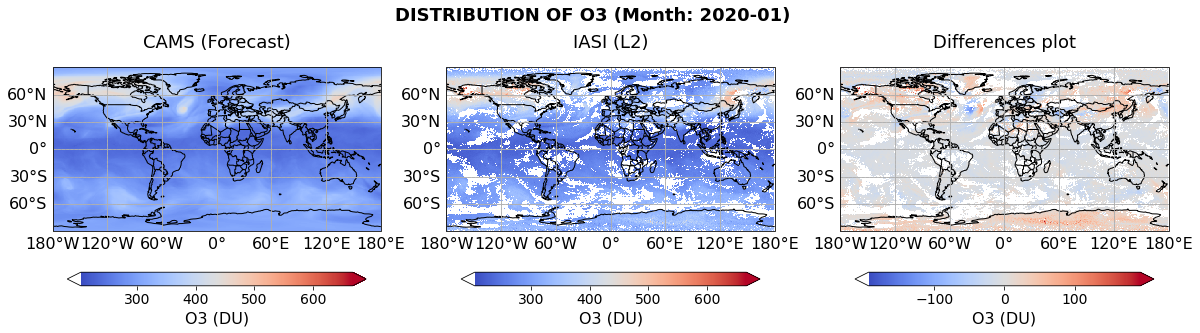

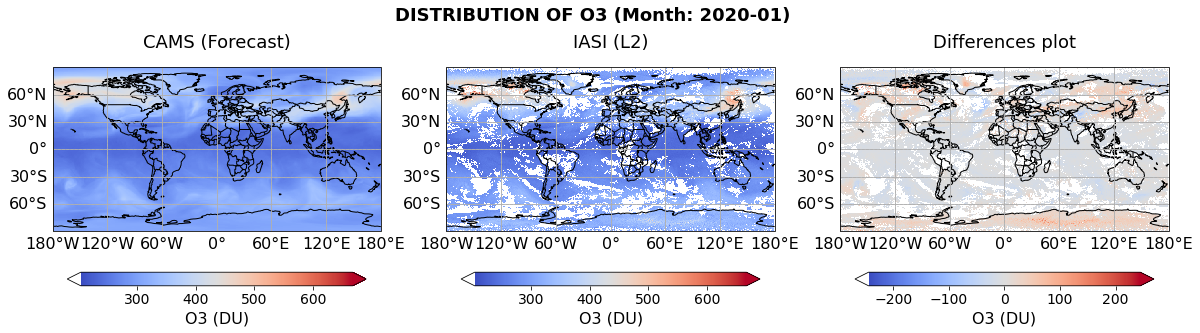

In [27]:
# Choose distribution (aggregated or individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.9, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

O3_total_column  \
lat_search lon_search latitude longitude time                          
50         15         49.5     14.5      2020-01-01       312.775371   
                                         2020-01-02       326.829449   
4          10         4.5      9.5       2020-01-01       236.742344   
                      5.5      9.5       2020-01-02       237.733825   
20         30         19.5     29.5      2020-01-01       233.488370   
                                         2020-01-02       247.916476   

                                                     step_index  model_column  \
lat_search lon_search latitude longitude time                                   
50         15         49.5     14.5      2020-01-01           0    333.953094   
                                         2020-01-02           0    307.844818   
4          10         4.5      9.5       2020-01-01           0    246.725922   
                      5.5      9.5       2020-01-02           0    245.576614   
20         30         19.5     29.5      2020-01-01           0    238.164536   
                                         2020-01-02           0    239.637207   

                                                     difference  
lat_search lon_search latitude longitude time                    
50         15         49.5     14.5      2020-01-01  -21.177724  
                                         2020-01-02   18.984631  
4          10         4.5      9.5       2020-01-01   -9.983578  
                      5.5      9.5       2020-01-02   -7.842789  
20         30         19.5     29.5      2020-01-01   -4.676165  
                                         2020-01-02    8.279269

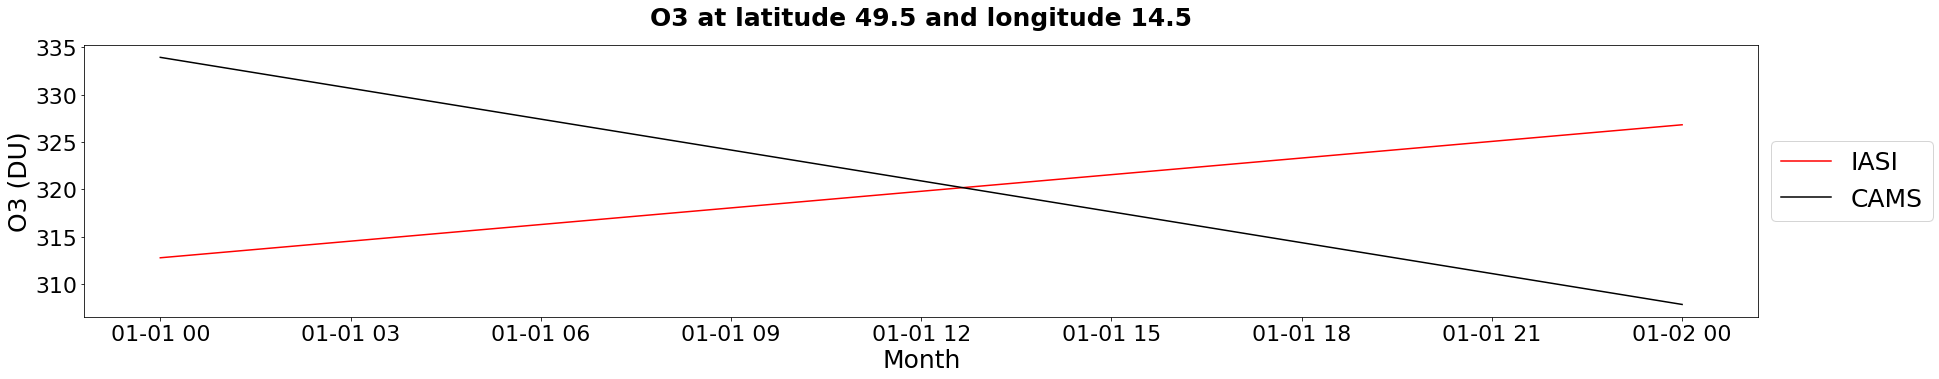

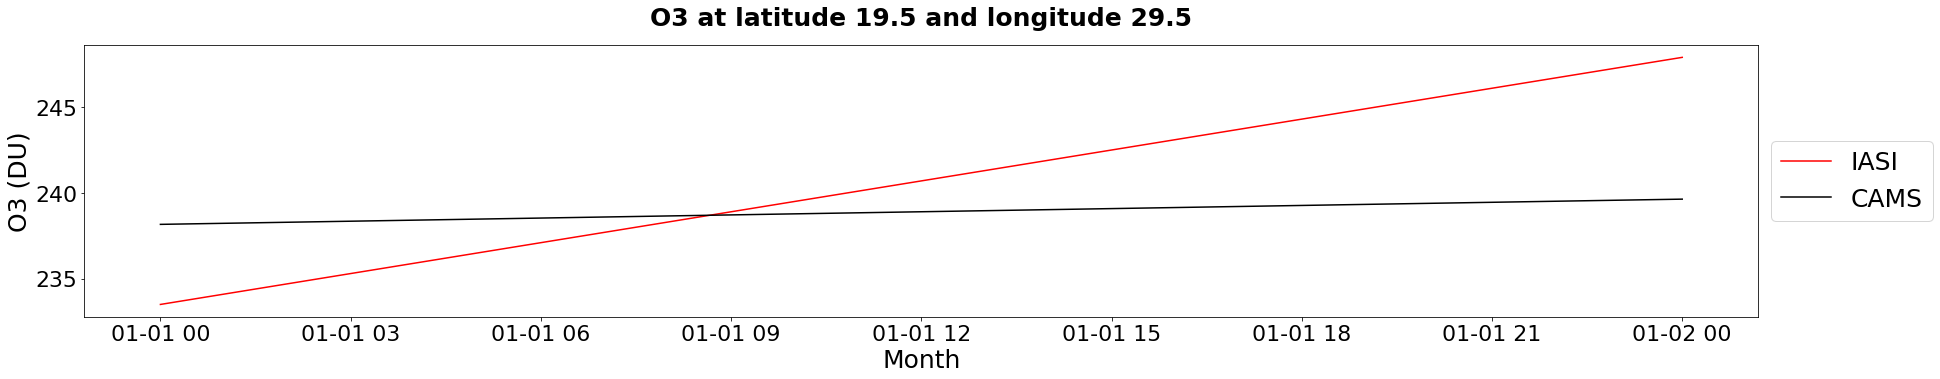

In [18]:
coords_search_list = (50, 15,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: O3_model = O3_sensor * 0.84 + (4.87E+01)
Coefficient of determination (R2): 0.88


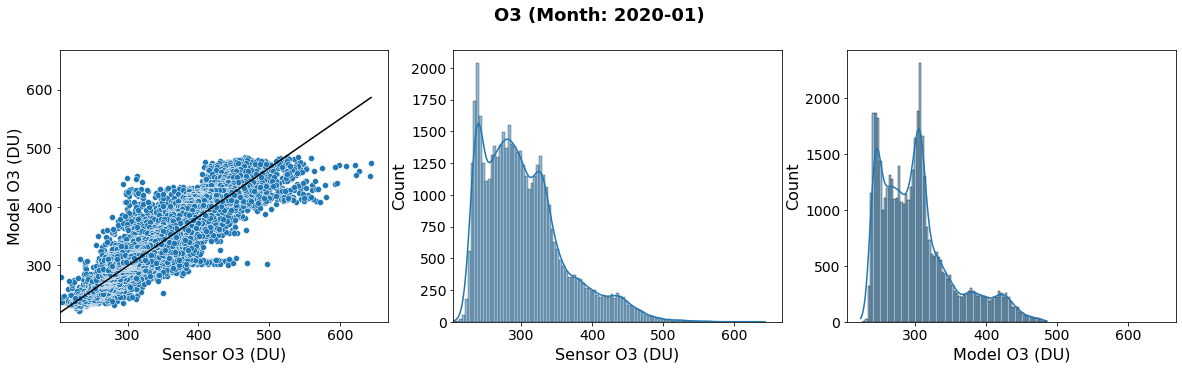

Fit equation: O3_model = O3_sensor * 0.84 + (4.67E+01)
Coefficient of determination (R2): 0.89


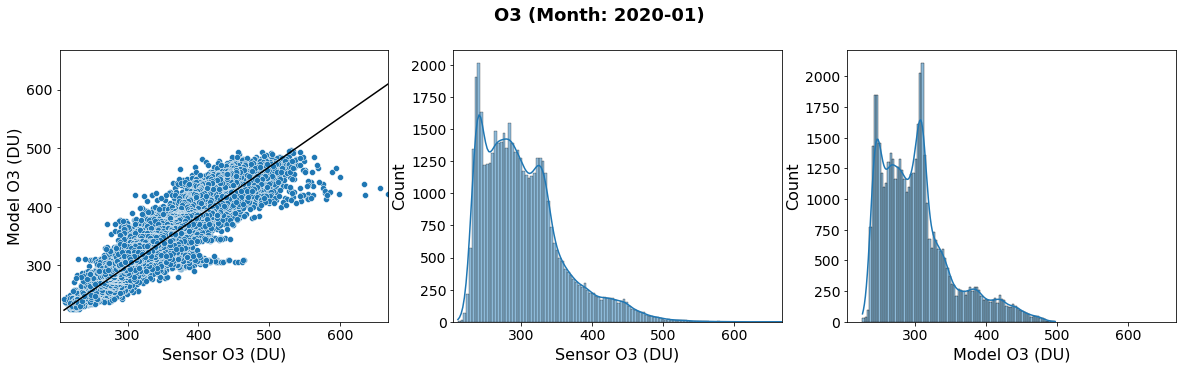

In [19]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [20]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2020-01-01,"((-180, -90), (180, 90))",0.879869,0.835317,48.678280
1,2020-01-02,"((-180, -90), (180, 90))",0.887634,0.842782,46.665061


## 9. Scatter plots by season

Fit equation: O3_model = O3_sensor * 0.84 + (4.77E+01)
Coefficient of determination (R2): 0.88


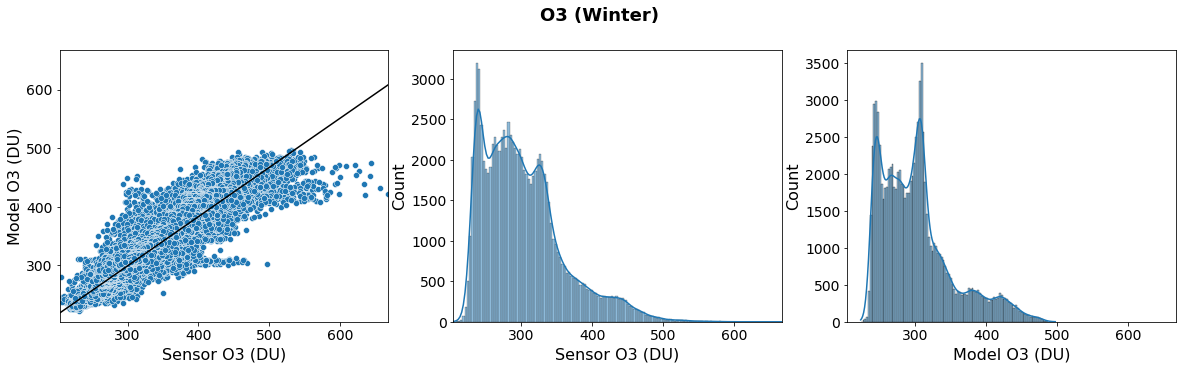

In [21]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [22]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Winter,"((-180, -90), (180, 90))",0.883667,0.838947,47.701255


## 10. Scatter plots by country (Google API required!)

In [23]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [24]:
#summary